# 在定义的数据集上微调 DETR 模型

## 场景

为了让本教程更具吸引力，让我们考虑一个现实的示例：建筑工人需要在施工区域保持最高的安全性。基本的安全协议要求随时佩戴头盔。由于有很多建筑工人，很难时刻监控每个人。

但如果我们能够拥有一个可以实时检测是否佩戴头盔的摄像系统，那就非常理想了，对吗？

因此，我们将微调一个轻量级的对象检测模型，以实现这一目标。让我们开始吧。

## 数据集

在上述场景中，我们将使用 Northeaster University China 提供的 [hardhat](https://huggingface.co/datasets/hf-vision/hardhat) 数据集。我们可以使用 🤗 `datasets` 下载并加载此数据集。

In [2]:
from datasets import load_dataset

dataset = load_dataset("anindya64/hardhat")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 5297
    })
    test: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 1766
    })
})

以上是一个 `DatasetDict`，这是一个包含整个数据集（按训练集和测试集划分）的高效字典结构。如上所见，在每个划分（训练集和测试集）下，我们有 `features` 和 `num_rows` 。在 `features` 中存储了以下的字段：

* `image`: 它是一个 Pillow 对象
* `image_id`: 用于对整体数据集的图像进行标识
* `width`: 图像的宽度
* `height`: 图像的高度
* `object`: 是一个字典数据结构，里面存储了目标检测的标注信息。

现在让我们看看每个数据点（在训练/测试集中）是什么样的。

In [3]:
dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 'image_id': 1,
 'width': 500,
 'height': 375,
 'objects': {'id': [1, 1],
  'area': [3068.0, 690.0],
  'bbox': [[178.0, 84.0, 52.0, 59.0], [111.0, 144.0, 23.0, 30.0]],
  'category': ['helmet', 'helmet']}}

从上面的单个样本的输出信息，可以看出每张图片可能存在多个目标框，在`object`中标注了目标的类别、目标区域矩阵形的面积、矩阵的坐标等。

现在我们来正确提取训练和测试样本。在本教程中，我们有大约 5000 个训练样本和 1700 个测试样本。

In [4]:
# 首先，提取训练集和测试集

train_dataset = dataset["train"]
test_dataset = dataset["test"]

现在我们知道样本数据点的内容，让我们开始绘制该样本。我们将首先绘制图像，然后绘制相应的边界框。

以下是我们要做的步骤：

1. 获取图像及其相应的高度和宽度。
2. 创建一个可在图像上绘制文本和线条的绘制对象。
3. 从样本中获取注释字典。
4. 遍历注释字典。
5. 对于每个对象，获取边界框坐标，即x（水平起始位置）、y（垂直起始位置）、w（边界框的宽度）、h（边界框的高度）。
6. 如果边界框的度量是归一化的，则进行缩放，否则保持不变。
7. 最后绘制矩形和类别文本。

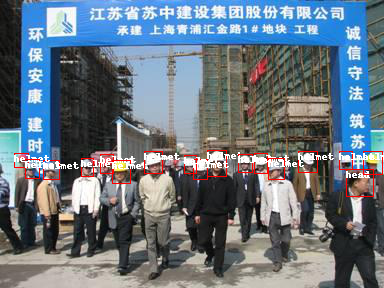

In [5]:
import numpy as np
from PIL import Image, ImageDraw


def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["id"])):
        box = annotations["bbox"][i]
        class_idx = annotations["id"][i]
        x, y, w, h = tuple(box)
        if max(box) > 1.0:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
        draw.text((x1, y1), annotations["category"][i], fill="white")
    return image


draw_image_from_idx(dataset=train_dataset, idx=10)

我们有一个函数来绘制单个图像，接下来编写一个简单的函数来使用上述代码绘制多个图像。这样可以帮助我们进行一些分析。

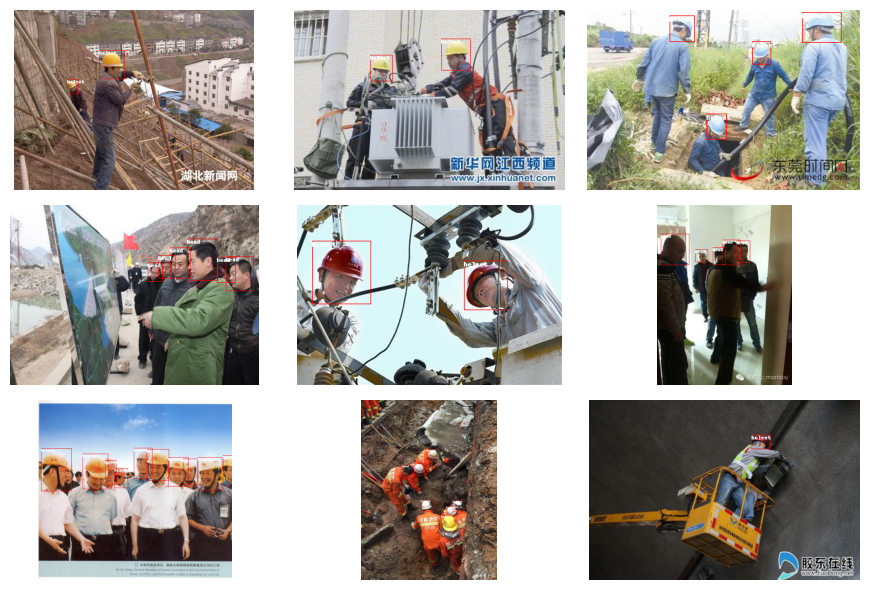

In [6]:
import matplotlib.pyplot as plt


def plot_images(dataset, indices):
    """
    绘制图像及其注释。
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 6))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # 绘制图像
        image = draw_image_from_idx(dataset, idx)

        # 在对应的子图上显示图像
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


# 现在使用该函数绘制图像

plot_images(train_dataset, range(9))

## AutoImageProcessor

在对模型进行微调之前，我们必须对数据进行预处理，以确保与预训练时的方法完全匹配。HuggingFace 的 [AutoImageProcessor](https://huggingface.co/docs/transformers/v4.36.0/en/model_doc/auto#transformers.AutoImageProcessor) 负责处理图像数据，以生成 `pixel_values`、`pixel_mask` 和 `labels`，供 DETR 模型进行训练。

现在，让我们从我们希望用来微调模型的相同检查点实例化图像处理器。

In [7]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50-dc5"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


## 数据集预处理

在将图像传递给 `image_processor` 之前，让我们还对图像及其对应的边界框应用不同类型的增强。

简单来说，增强是一组随机转换，如旋转、调整大小等。这些转换被应用于图像，以获得更多样本，并使视觉模型在不同图像条件下更加健壮。我们将使用 [albumentations](https://github.com/albumentations-team/albumentations) 库来实现这一点。它允许您创建图像的随机变换，从而增加训练样本数量。

In [8]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

一旦我们初始化了所有的转换，我们需要创建一个函数来格式化注释，并返回特定格式的注释列表。

这是因为 `image_processor` 期望注释的格式如下：`{'image_id': int, 'annotations': List[Dict]}`，其中每个字典是一个 COCO 对象注释。

In [9]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

最后，我们将图像和注释的转换结合起来，对整个数据集批量进行转换。

以下是执行此操作的最终代码：

In [10]:
# 批量转换


def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["id"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

最后，你只需将此预处理函数应用于整个数据集。你可以通过使用 HuggingFace 🤗 的 [Datasets with transform](https://huggingface.co/docs/datasets/v2.15.0/en/package_reference/main_classes#datasets.Dataset.with_transform) 方法来实现。

In [11]:
# 对训练集和测试集进行转换

train_dataset_transformed = train_dataset.with_transform(transform_aug_ann)
test_dataset_transformed = test_dataset.with_transform(transform_aug_ann)

现在，让我们看看转换后的训练集样本是什么样的，这将返回一个张量字典。我们主要需要的是代表图像的 `pixel_values`、作为注意力掩码的 `pixel_mask` 和标签 `labels`。

In [12]:
train_dataset_transformed[0]

{'pixel_values': tensor([[[-0.9020, -0.9020, -0.9020,  ..., -1.1075, -1.2788, -1.3987],
          [-0.9020, -0.9020, -0.9020,  ..., -1.1075, -1.2788, -1.4158],
          [-0.9020, -0.9020, -0.9192,  ..., -1.1075, -1.2959, -1.4329],
          ...,
          [-1.2959, -1.3815, -1.5185,  ..., -1.5870, -1.6555, -1.7069],
          [-1.2959, -1.3987, -1.5357,  ..., -1.6042, -1.6898, -1.7412],
          [-1.2959, -1.3987, -1.5357,  ..., -1.6213, -1.7069, -1.7754]],
 
         [[-0.8627, -0.8627, -0.8627,  ..., -0.6527, -0.8452, -0.9678],
          [-0.8627, -0.8627, -0.8627,  ..., -0.6702, -0.8627, -1.0028],
          [-0.8627, -0.8627, -0.8803,  ..., -0.6877, -0.8978, -1.0378],
          ...,
          [-0.8452, -0.9503, -1.1253,  ..., -1.2829, -1.3529, -1.3880],
          [-0.8452, -0.9678, -1.1429,  ..., -1.3004, -1.3880, -1.4230],
          [-0.8452, -0.9678, -1.1429,  ..., -1.3179, -1.4055, -1.4580]],
 
         [[-0.5495, -0.5495, -0.5495,  ...,  0.0605, -0.1312, -0.2707],
          [-

我们快完成了 🚀。作为最后的预处理步骤，我们需要编写一个自定义的 `collate_fn`。那么，什么是 `collate_fn`？

`collate_fn` 负责将数据集中的一组样本转换为适合模型输入格式的批次。

一般来说，`DataCollator` 通常执行填充、截断等任务。在自定义 collate 函数中，我们通常定义如何将数据分组为批次，或简单地说，如何表示每个批次。

数据整合器主要是将数据组合在一起并进行预处理。让我们来编写我们的 collate 函数。

In [13]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

## 训练 DETR 模型

目前，所有繁重的工作已经完成了。现在，剩下的就是一步一步组装每个部分。让我们开始吧！

训练过程包含以下步骤：

1. 使用与预处理相同的检查点，通过 [AutoModelForObjectDetection](https://huggingface.co/docs/transformers/v4.36.0/en/model_doc/auto#transformers.AutoModelForObjectDetection) 加载基础（预训练）模型。

2. 在 [TrainingArguments](https://huggingface.co/docs/transformers/v4.36.0/en/main_classes/trainer#transformers.TrainingArguments) 中定义所有超参数和附加参数。

3. 将训练参数与模型、数据集和图像一起传递到 [HuggingFace Trainer](https://huggingface.co/docs/transformers/v4.36.0/en/main_classes/trainer#transformers.Trainer)。

4. 调用 `train()` 方法微调模型。

在加载与预处理相同的检查点时，请记得传入您之前从数据集元数据创建的 `label2id` 和 `id2label` 映射。此外，我们指定 `ignore_mismatched_sizes=True`，以替换现有的分类头部为新的分类头部。

In [14]:
from transformers import AutoModelForObjectDetection

id2label = {0: "head", 1: "helmet", 2: "person"}
label2id = {v: k for k, v in id2label.items()}


model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    torch_dtype=torch.bfloat16,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50-dc5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model check

完成后，开始训练模型。首先定义训练参数，然后定义使用这些参数进行训练的 trainer 对象，如下所示：

In [15]:
from transformers import TrainingArguments
from transformers import Trainer

# 定义训练参数

training_args = TrainingArguments(
    output_dir="detr-resnet-50-hardhat-finetuned",
    per_device_train_batch_size=4,
    num_train_epochs=3,
    max_steps=5000,
    bf16=True,
    save_steps=500,
    logging_steps=100,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
)

# 定义 trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset_transformed,
    eval_dataset=test_dataset_transformed,
    processing_class=image_processor,
)

trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


[2024-11-13 14:13:10,263] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio
collect2: error: ld returned 1 exit status
/data/envs/cuda-12.1/lib64/libcufile.so: undefined reference to `dlopen'
/data/envs/cuda-12.1/lib64/libcufile.so: undefined reference to `dlclose'
/data/envs/cuda-12.1/lib64/libcufile.so: undefined reference to `dlerror'
/data/envs/cuda-12.1/lib64/libcufile.so: undefined reference to `dlsym'
collect2: error: ld returned 1 exit status
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
100,3.895800
200,3.463300
300,3.130700
400,2.855800
500,2.707900
600,2.542100
700,2.475900
800,2.376700
900,2.360400
1000,2.354000


TrainOutput(global_step=5000, training_loss=2.3129985290527344, metrics={'train_runtime': 8710.1461, 'train_samples_per_second': 2.296, 'train_steps_per_second': 0.574, 'total_flos': 9.55189729188864e+18, 'train_loss': 2.3129985290527344, 'epoch': 3.7735849056603774})

现在我们将尝试对新微调的模型进行推理。在本教程中，我们将针对以下图像进行测试：

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/hf-vision/course-assets/resolve/main/test_input_for_od.png" alt="input-test-image">
<p>图3：input-test-image</p>
</div>

我们首先编写一个非常简单的代码来进行新图像的目标检测推理。我们从单张图片的推理开始，随后我们将整合一切并将其制作为一个函数。

In [ ]:
import requests
from transformers import pipeline

# 下载样本图像

url = "https://huggingface.co/datasets/hf-vision/course-assets/resolve/main/test-helmet-object-detection.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# 创建目标检测 pipeline

obj_detector = pipeline(
    "object-detection", model=model, image_processor=image_processor
)
results = obj_detector(train_dataset[0]["image"])

print(results)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[]


现在让我们编写一个非常简单的函数来将结果绘制在图像上。我们从结果中获得分数、标签和相应的边界框坐标，这些将用于在图像中绘制。

In [ ]:
def plot_results(image, results, threshold=0.7):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    for result in results:
        score = result["score"]
        label = result["label"]
        box = list(result["box"].values())
        if score > threshold:
            x, y, x2, y2 = tuple(box)
            draw.rectangle((x, y, x2, y2), outline="red", width=1)
            draw.text((x, y), label, fill="white")
            draw.text(
                (x + 0.5, y - 0.5),
                text=str(score),
                fill="green" if score > 0.7 else "red",
            )
    return image

最后，使用该函数处理我们使用的相同测试图像。

In [ ]:
results = obj_detector(image)
plot_results(image, results)

现在，让我们将所有内容组合成一个简单的函数。

In [ ]:
def predict(image, pipeline, threshold=0.7):
    results = pipeline(image)
    return plot_results(image, results, threshold)


# 让我们测试另一个测试图像
img = test_dataset[0]["image"]
predict(img, obj_detector)

让我们使用我们的推理函数对多个图像进行绘制。

In [ ]:
from tqdm.auto import tqdm


def plot_images(dataset, indices):
    """
    绘制图像及其注释。
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in tqdm(enumerate(indices), total=len(indices)):
        row = i // num_cols
        col = i % num_cols

        # 绘制图像
        image = predict(dataset[idx]["image"], obj_detector)

        # 在相应的子图上显示图像
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


plot_images(test_dataset, range(6))

这结果还不错。如果我们进一步微调，还可以改善结果。您可以在此找到该微调检查点 [here](hf-vision/detr-resnet-50-dc5-harhat-finetuned)。